In [9]:
import harp
import numpy as np
from pathlib import Path
import os
import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
import copy

In [10]:
base_path = Path('/home/ikharitonov/Desktop/')
dataset_name = '2024-05-10T14-04-37'

In [11]:
def get_register_object(register_number, harp_board='h1'):
    
    h1_reader = harp.create_reader(f'h1-device.yml', epoch=harp.REFERENCE_EPOCH)
    h2_reader = harp.create_reader(f'h2-device.yml', epoch=harp.REFERENCE_EPOCH)
    reference_dict = {
        'h1': {
            32: h1_reader.Cam0Event,
            33: h1_reader.Cam1Event,
            38: h1_reader.StartAndStop,
            46: h1_reader.OpticalTrackingRead
        },
        'h2': {
            38: h2_reader.Encoder,
            39: h2_reader.AnalogInput,
            42: h2_reader.ImmediatePulses
        }
    }
    return reference_dict[harp_board][register_number]

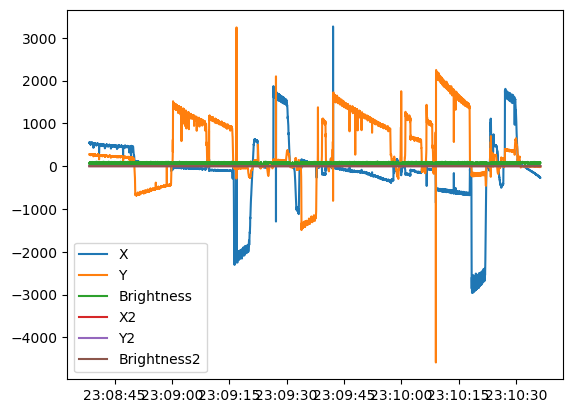

In [12]:
optical_stream_df = utils.load(get_register_object(46, 'h1'), base_path/dataset_name/'HarpDataH1')

plt.figure()
plt.plot(optical_stream_df['OpticalTrackingRead0X'], label='X')
plt.plot(optical_stream_df['OpticalTrackingRead0Y'], label='Y')
plt.plot(optical_stream_df['OpticalTrackingRead0Brightness'], label='Brightness')
plt.plot(optical_stream_df['OpticalTrackingRead1X'], label='X2')
plt.plot(optical_stream_df['OpticalTrackingRead1Y'], label='Y2')
plt.plot(optical_stream_df['OpticalTrackingRead1Brightness'], label='Brightness2')
plt.legend()
plt.show()

In [13]:
optical_stream_x = optical_stream_df['OpticalTrackingRead0X']
print(len(optical_stream_x))
print(optical_stream_x)

11794
Time
1904-01-03 23:08:38.420256    541
1904-01-03 23:08:38.430240    548
1904-01-03 23:08:38.440256    560
1904-01-03 23:08:38.450240    548
1904-01-03 23:08:38.460256    549
                             ... 
1904-01-03 23:10:36.310240   -267
1904-01-03 23:10:36.320256   -266
1904-01-03 23:10:36.330240   -267
1904-01-03 23:10:36.340256   -266
1904-01-03 23:10:36.350240   -268
Name: OpticalTrackingRead0X, Length: 11794, dtype: int16


## Checking inter-timestamp intervals (optic flow_x)

In [14]:
print('All unique element-wise differences between timestamps (in nanoseconds)', np.unique(np.diff(optical_stream_x.index).astype(np.uint32)))

All unique element-wise differences between timestamps (in nanoseconds) [ 9984000 10016000]


Text(0.5, 0, 'Inter-timestamp interval (seconds)')

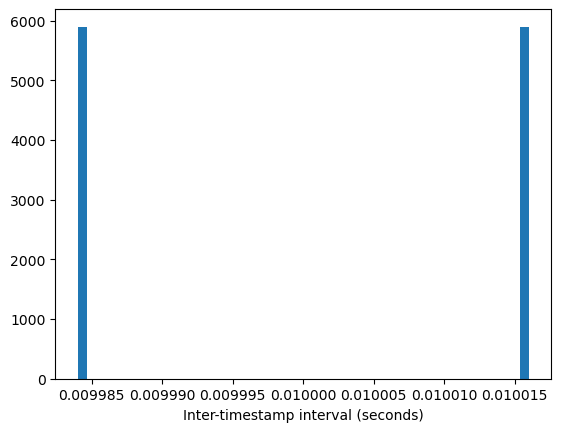

In [15]:
plt.hist(np.diff(optical_stream_x.index).astype(np.uint32)* (10**-9), bins=50)
plt.xlabel('Inter-timestamp interval (seconds)')

In [16]:
(9984000+10016000)* (10**-9)

0.02

## Comparing clocked and non-clocked datasets

In [17]:
h1_reader = harp.create_reader('h1-device.yml', epoch=harp.REFERENCE_EPOCH)
h2_reader = harp.create_reader('h2-device.yml', epoch=harp.REFERENCE_EPOCH)
session_data_reader = utils.SessionData()

base_path = '/home/ikharitonov/Desktop/'

dataset_name = '2024-05-10T14-04-37'
nonclocked_h1_46 = utils.load(h1_reader.OpticalTrackingRead, base_path + dataset_name + '/HarpDataH1/')
nonclocked_h2_42 = utils.load(h2_reader.ImmediatePulses, base_path + dataset_name + '/HarpDataH2/')
nonclocked_h2_38 = utils.load(h2_reader.Encoder, base_path + dataset_name + '/HarpDataH2/')

dataset_name = '2024-06-26T13-51-40_gain_A'
clocked_h1_46 = utils.load(h1_reader.OpticalTrackingRead, base_path + dataset_name + '/HarpDataH1/')
clocked_h2_42 = utils.load(h2_reader.ImmediatePulses, base_path + dataset_name + '/HarpDataH2/')
clocked_h2_38 = utils.load(h2_reader.Encoder, base_path + dataset_name + '/HarpDataH2/')

In [18]:
print(nonclocked_h1_46.index[0])
print(nonclocked_h1_46.index[1])
print(nonclocked_h1_46.index[2])
print(nonclocked_h1_46.index[3])
print(nonclocked_h1_46.index[4])
print(nonclocked_h1_46.index[5])
print(nonclocked_h1_46.index[6])
print(nonclocked_h1_46.index[7])

1904-01-03 23:08:38.420256
1904-01-03 23:08:38.430240
1904-01-03 23:08:38.440256
1904-01-03 23:08:38.450240
1904-01-03 23:08:38.460256
1904-01-03 23:08:38.470240
1904-01-03 23:08:38.480256
1904-01-03 23:08:38.490240


In [19]:
print(nonclocked_h2_38.index[0])
print(nonclocked_h2_38.index[1])
print(nonclocked_h2_38.index[2])
print(nonclocked_h2_38.index[3])
print(nonclocked_h2_38.index[4])
print(nonclocked_h2_38.index[5])
print(np.diff(nonclocked_h2_38.index[:6]))

1904-01-03 23:09:30.093984
1904-01-03 23:09:30.124000
1904-01-03 23:09:30.409984
1904-01-03 23:09:30.425504
1904-01-03 23:09:30.433984
1904-01-03 23:09:30.437984
[ 30016000 285984000  15520000   8480000   4000000]


In [20]:
clocked_h1_46.index[0]

Timestamp('1904-01-13 05:45:10.220256')

In [21]:
clocked_h2_42.index[0]

Timestamp('1904-01-13 05:45:02.807488')

In [22]:
clocked_h2_42.index[1]

Timestamp('1904-01-13 05:45:02.808480')

In [23]:
clocked_h2_38.index[0]

Timestamp('1904-01-13 05:45:02.822496')

In [24]:
clocked_h2_38.index[1]

Timestamp('1904-01-13 05:45:02.841984')

In [25]:
print(clocked_h1_46.index[0])
print(clocked_h1_46.index[1])
print(clocked_h1_46.index[2])
print(clocked_h1_46.index[3])
print(clocked_h1_46.index[4])
print(clocked_h1_46.index[5])
print(np.diff(clocked_h1_46.index[:6]))

1904-01-13 05:45:10.220256
1904-01-13 05:45:10.230240
1904-01-13 05:45:10.240256
1904-01-13 05:45:10.250240
1904-01-13 05:45:10.260256
1904-01-13 05:45:10.270240
[ 9984000 10016000  9984000 10016000  9984000]


In [26]:
print(clocked_h2_38.index[0])
print(clocked_h2_38.index[1])
print(clocked_h2_38.index[2])
print(clocked_h2_38.index[3])
print(clocked_h2_38.index[4])
print(clocked_h2_38.index[5])
print(np.diff(clocked_h2_38.index[:6]))

1904-01-13 05:45:02.822496
1904-01-13 05:45:02.841984
1904-01-13 05:45:02.856480
1904-01-13 05:45:02.879488
1904-01-13 05:45:02.899488
1904-01-13 05:45:02.917504
[19488000 14496000 23008000 20000000 18016000]


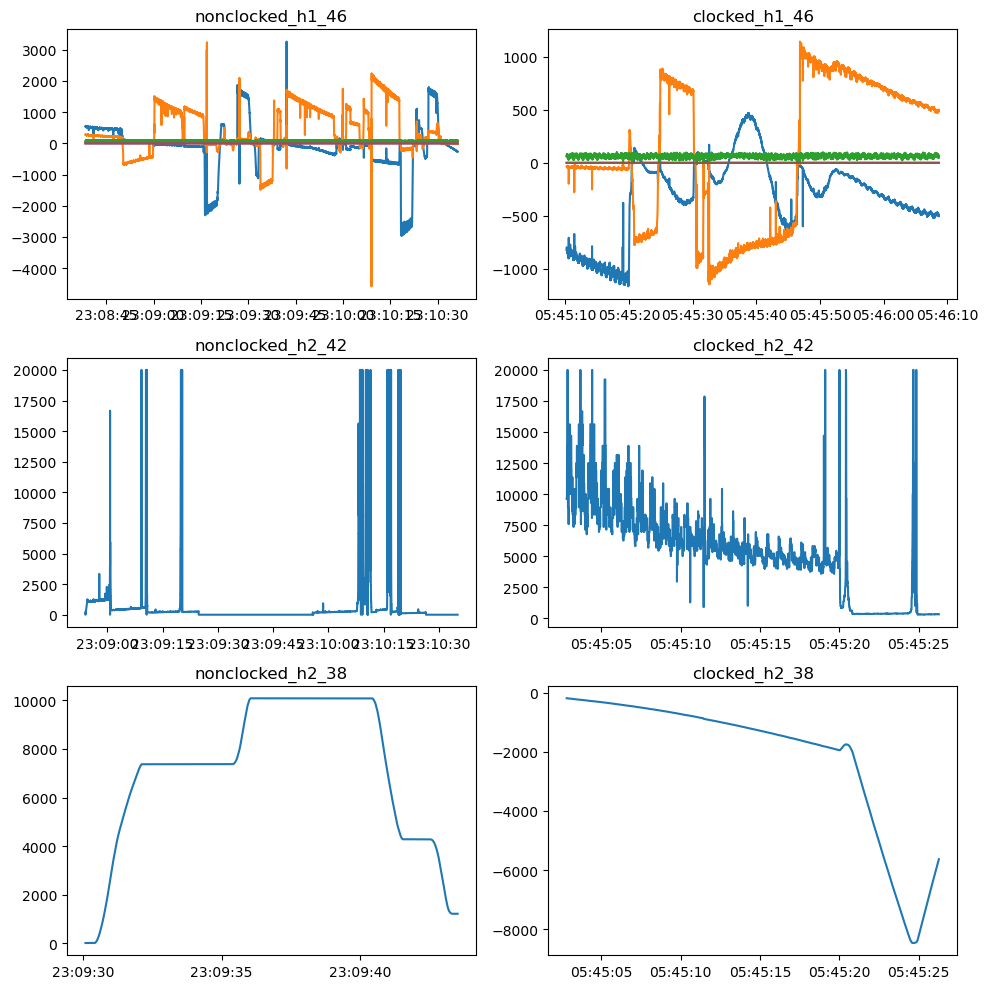

In [27]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

ax[0][0].plot(nonclocked_h1_46)
ax[0][0].set_title('nonclocked_h1_46')

ax[1][0].plot(nonclocked_h2_42)
ax[1][0].set_title('nonclocked_h2_42')

ax[0][1].plot(clocked_h1_46)
ax[0][1].set_title('clocked_h1_46')

ax[1][1].plot(clocked_h2_42)
ax[1][1].set_title('clocked_h2_42')

ax[2][0].plot(nonclocked_h2_38)
ax[2][0].set_title('nonclocked_h2_38')

ax[2][1].plot(clocked_h2_38)
ax[2][1].set_title('clocked_h2_38')

plt.tight_layout()
plt.show()

## Checking particular timestamp

In [28]:
timestamp = '1904-01-13 05:45:19.910240'

In [29]:
clocked_h1_46[clocked_h1_46.index==timestamp]

,OpticalTrackingRead0X,OpticalTrackingRead0Y,OpticalTrackingRead0Brightness,OpticalTrackingRead1X,OpticalTrackingRead1Y,OpticalTrackingRead1Brightness
Time,,,,,,
1904-01-13 05:45:19.910240,-1139,-57,46,0,0,0


In [30]:
clocked_h2_42[clocked_h2_42.index==timestamp]

,ImmediatePulses
Time,


### Lomb–Scargle periodogram

Lomb-Scargle periodogram was developed by Lomb [Lomb, N.R., 1976] and further extended by Scargle [Scargle, J.D., 1982] to find, and test the significance of weak periodic signals with uneven temporal sampling. Lomb–Scargle periodogram is a method that allows efﬁcient computation of a Fourier-like power spectrum estimator from unevenly sampled data, resulting in an intuitive means of determining the period of oscillation.
https://www.earthinversion.com/techniques/how-to-deal-with-irregular-sparse-data-set/

In [31]:
f = np.linspace(0.001, 10**20, 1000)
pgram = signal.lombscargle(clocked_h2_42.index.to_numpy(), clocked_h2_42.values[:,0], f, normalize=True)
pgram2 = signal.lombscargle((clocked_h2_42.index - clocked_h2_42.index[0]).total_seconds().to_numpy(), clocked_h2_42.values[:,0], f, normalize=True)

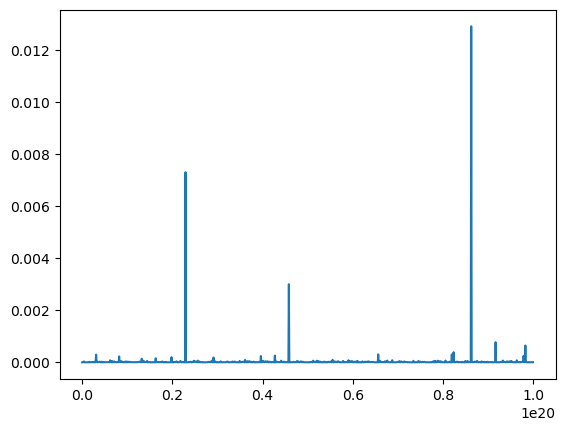

In [32]:
plt.plot(f,pgram)

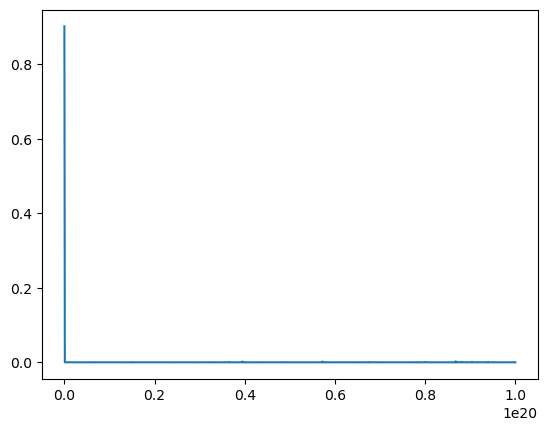

In [33]:
plt.plot(f,pgram2)